<a href="https://colab.research.google.com/github/jgalazka/ERCC_analysis/blob/main/Copy_of_GLDS_235_Liver_ERCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeneLab ERCC spike-in analysis notebook

This notebook contains an analysis of RNA-seq counts data generated from ERCC spike-ins.

Here GLDS-235 Liver is analyzed


## Section 1: Setting up the notebook

In [ ]:
# import python packages
import pandas as pd
import numpy as np
from urllib.request import urlopen, quote, urlretrieve
from json import loads
from re import search
import zipfile
import seaborn as sns
from scipy.stats import linregress

In [ ]:
# Function to pull metadata zip from GeneLab
# Credit to Kirill Grigorev
GENELAB_ROOT = "https://genelab-data.ndc.nasa.gov"
GLDS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/data/"
FILELISTINGS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/filelistings/"
ISA_ZIP_REGEX = r'.*_metadata_.*[_-]ISA\.zip$'

def read_json(url):
    with urlopen(url) as response:
        return loads(response.read().decode())

def get_isa(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    isa_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(ISA_ZIP_REGEX, entry["file_name"])
    ]
    if len(isa_entries) == 0:
        raise ValueError("Unexpected: no ISAs found")
    elif len(isa_entries) > 1:
        raise ValueError("Unexpected: multiple files match the ISA regex")
    else:
        entry = isa_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

In [ ]:
# Function to pull unnormalized counts from GeneLab
# Credit to Kirill Grigorev

RAW_COUNTS_REGEX = r'.*_rna_seq_Unnormalized_Counts.csv'

def get_rawcounts(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    raw_counts_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(RAW_COUNTS_REGEX, entry["file_name"])
    ]
    if len(raw_counts_entries) == 0:
        raise ValueError("Unexpected: no Raw Counts found")
    elif len(raw_counts_entries) > 1:
        raise ValueError("Unexpected: multiple files match the Raw Counts regex")
    else:
        entry = raw_counts_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

## Get and parse data and metadata
Get ISA, counts, and ERCC data.

In [ ]:
accession = 'GLDS-235' # Change this as necessary
isaurl = get_isa(accession)[3]
filehandle, _ = urlretrieve(isaurl)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist() # Print contents of zip file. Pick relevant one from list

['s_Freezing Study_Liver.txt',
 'i_Investigation.txt',
 'a_freezing_study_liver_transcription_profiling_RNA_Sequencing_(RNA-Seq).txt']

In [ ]:
sample_file = zip_file_object.namelist()[0]
file = zip_file_object.open(sample_file)
sample_table = pd.read_csv(zip_file_object.open(sample_file), sep='\t')

assay_file = zip_file_object.namelist()[2]
file = zip_file_object.open(assay_file)
assay_table = pd.read_csv(zip_file_object.open(assay_file), sep='\t')

In [ ]:
sample_table.head()

,Source Name,Characteristics[Organism],Term Source REF,Term Accession Number,Comment[Animal Source],Characteristics[Strain],Characteristics[Genotype],"Characteristics[sex,http://purl.obolibrary.org/obo/PATO_0000047,EFO]",Term Source REF.1,Term Accession Number.1,"Characteristics[age,http://www.ebi.ac.uk/efo/EFO_0000246,EFO]",Unit,Term Source REF.2,Term Accession Number.2,Parameter Value[Habitat],Term Source REF.3,Term Accession Number.3,"Characteristics[diet,http://www.ebi.ac.uk/efo/EFO_0002755,EFO]",Term Source REF.4,Term Accession Number.4,Parameter Value[Feeding Schedule],Term Source REF.5,Term Accession Number.5,Protocol REF,Factor Value[Euthanasia Method],Term Source REF.6,Term Accession Number.6,Protocol REF.1,Sample Name,Factor Value[Carcass Preservation Method],Term Source REF.7,Term Accession Number.7,Factor Value[Tissue Preservation Method],Term Source REF.8,Term Accession Number.8,Factor Value[Dissection Condition],Term Source REF.9,Term Accession Number.9,Factor Value[Tissue Homogenate Preservation Time at -80C in RLT Buffer],Unit.1,Term Source REF.10,Term Accession Number.10,Material Type,Term Source REF.11,Term Accession Number.11,Comment[Carcass Weight (g)]
0,M31,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,22.4
1,M32,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,23.7
2,M33,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,25.7
3,M34,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,22.5
4,M31,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanas

In [ ]:
assay_table.head()

,Sample Name,Protocol REF,Parameter Value[QA Instrument],Parameter Value[QA Assay],Parameter Value[QA Score],Unit,Term Source REF,Term Accession Number,Extract Name,Protocol REF.1,Parameter Value[Spike-in Quality Control],Term Source REF.1,Term Accession Number.1,Parameter Value[Spike-in Mix Number],Term Source REF.2,Term Accession Number.2,Protocol REF.2,Parameter Value[library selection],Parameter Value[library layout],Parameter Value[stranded],Parameter Value[Library QA Instrument],Term Source REF.3,Term Accession Number.3,Parameter Value[Library QA Assay],Term Source REF.4,Term Accession Number.4,Parameter Value[Fragment Size],Unit.1,Term Source REF.5,Term Accession Number.5,Protocol REF.3,Parameter Value[sequencing instrument],"Parameter Value[Read Length,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C153362,NCIT]",Unit.2,Term Source REF.6,Term Accession Number.6,Parameter Value[base caller],Assay Name,Parameter Value[rRNA Contamination],Unit.3,...,Term Accession Number.7,"Parameter Value[Read Depth,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C155320,NCIT]",Unit.4,Term Source REF.8,Term Accession Number.8,Raw Data File,Characteristics[Fastqc File Names],Term Source REF.9,Term Accession Number.9,Characteristics[MultiQC File Names],Term Source REF.10,Term Accession Number.10,Protocol REF.4,"Characteristics[trimmed sequence data,http://purl.obolibrary.org/obo/OBI_0002569,OBI]",Term Source REF.11,Term Accession Number.11,Characteristics[Trimmed Sequence Data Fastqc File],Term Source REF.12,Term Accession Number.12,Characteristics[Trimmed Sequence Data Multiqc File],Term Source REF.13,Term Accession Number.13,Characteristics[Trimmed Report],Term Source REF.14,Term Accession Number.14,"Characteristics[aligned sequence data,http://purl.obolibrary.org/obo/OBI_0002580,OBI]",Term Source REF.15,Term Accession Number.15,Characteristics[Alignment Logs],Term Source REF.16,Term Accession Number.16,Characteristics[Raw Counts Data File],Term Source REF.17,Term Accession Number.17,Characteristics[Normalized Counts Data File],Term Source REF.18,Term Accession Number.18,"Characteristics[differential expression analysis data transformation,http://purl.obolibrary.org/obo/OBI_0000650,OBI]",Term Source REF.19,Term Accession Number.19
0,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,7.1,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31_RNA_ALQ2,spike-in control protocol,ERCC ExFold RNA Spike-In Mix,NaN,NaN,Mix 1,NaN,NaN,library construction,PCR,PAIRED,Stranded,Agilent 4200 TapeStation,NaN,NaN,D1000 ScreenTape,NaN,NaN,332,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,nucleic acid sequencing,Illumina NovaSeq 6000,149,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,bcl2fastq,rna-seq,0.16,percent,...,http://purl.obolibrary.org/obo/UO_0000187,84828509,read,SO,http://purl.obolibrary.org/obo/SO_0000150,GLDS-235_rna-seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,GLDS-235_rna-seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,"GLDS-235_rna-seq_raw_multiqc_data.zip, GLDS-23...",NaN,NaN,GeneLab RNAseq data processing protocol,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,"GLDS-235_rna_seq_trimmed_multiqc_report.html, ...",NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,"GLDS-235_rna_seq_Normalized_Counts.csv, GLDS-2...",NaN,NaN,"GLDS-235_rna_seq_contrasts.csv, GLDS-235_rna_s...",NaN,NaN
1,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,6.9,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32_RNA_ALQ1,spike-in control protocol,ERCC ExFold RNA Spi

In [ ]:
# Get raw counts table
raw_counts_file = get_rawcounts('GLDS-235')[3]
raw_counts_table = pd.read_csv(raw_counts_file, index_col=0)
raw_counts_table.index.rename('Gene_ID', inplace=True)
raw_counts_table.head()

,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep5_M35,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep6_M36,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep6_M12,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep1_M13,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep2_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep3_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep4_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep5_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep6_M18,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep1_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep2_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep3_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep4_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep5_M18,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep5_M23,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep6_M24,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep5_M23,Mmus_C57-6J_LVR_Euth_I_DI_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_DI_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_DI_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_DI_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_DI_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_DI_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_LN2_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_LN2_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_LN2_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_LN2_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_LN2_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_LN2_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep6_M6,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep5_M29,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep6_M30
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,12.0,13.0,18.0,17.0,10.0,4.0,5.0,0.0,6.0,3.0,2.0,43.0,1.0,39.0,7.0,7.0,12.0,44.0,14.0,4.0,20.0,2.0,7.0,5.0,5.0,13.0,17.0,23.0,13.0,16.0,17.0,9.0,9.0,15.0,13.0,6.0,2.0,13.0,1.0,16.0,1.0,11.0,0.0,3.0,1.0,6.0,6.0,33.0,2.0,7.0,4.0,2.0,5.0,7.0,8.0,6.0,2.0,10.0,1.0,11.0,2.0,16.0,4.0,5.0,6.0,12.0,48.0,6.0,43.0,12.0,4.0,1.0,7.0,9.0,2.0
ENSMUSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000028,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,

In [ ]:
# Get ERCC counts
ercc_counts = raw_counts_table[raw_counts_table.index.str.contains('^ERCC-')]
ercc_counts.head()

,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep5_M35,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep6_M36,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep6_M12,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep1_M13,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep2_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep3_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep4_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep5_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep6_M18,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep1_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep2_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep3_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep4_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep5_M18,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep5_M23,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep6_M24,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep5_M23,Mmus_C57-6J_LVR_Euth_I_DI_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_DI_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_DI_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_DI_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_DI_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_DI_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_LN2_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_LN2_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_LN2_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_LN2_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_LN2_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_LN2_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep6_M6,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep5_M29,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep6_M30
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,1150.0,0.0,1833.0,3402.0,2085.0,99.0,652.0,104.0,1222.0,55.0,327.0,0.0,253.0,4853.0,447.0,2116.0,943.0,6163.0,1758.0,724.0,1391.0,257.0,518.0,201.0,215.0,1485.0,0.0,2707.0,5356.0,3715.0,3605.0,581.0,2640.0,1530.0,1058.0,217.0,217.0,0.0,210.0,3715.0,191.0,3101.0,396.0,726.0,1214.0,1073.0,2136.0,8205.0,261.0,814.0,341.0,1154.0,328.0,680.0,1675.0,745.0,367.0,245.0,333.0,659.0,437.0,1137.0,260.0,412.0,714.0,2335.0,0.0,779.0,6436.0,1304.0,150.0,277.0,227.0,914.0,281.0
ERCC-00003,168.0,0.0,178.0,191.0,138.0,12.0,44.0,7.0,87.0,7.0,20.0,0.0,23.0,479.0,29.0,121.0,201.0,656.0,147.0,45.0,129.0,27.0,43.0,22.0,18.0,210.0,0.0,245.0,465.0,285.0,211.0,41.0,154.0,124.0,44.0,34.0,20.0,0.0,23.0,298.0,14.0,174.0,25.0,69.0,65.0,79.0,226.0,613.0,19.0,40.0,14.0,84.0,18.0,57.0,116.0,56.0,15.0,24.0,20.0,113.0,26.0,126.0,20.0,53.0,34.0,141.0,

In [ ]:
# Get ERCC files
ercc_url = 'https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095046.txt'
filehandle, _ = urlretrieve(ercc_url)
ercc_table = pd.read_csv(filehandle, '\t')
ercc_table.head()

,Re-sort ID,ERCC ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
0,1,ERCC-00130,A,30000.00,7500.0000,4.0,2.0
1,2,ERCC-00004,A,7500.00,1875.0000,4.0,2.0
2,3,ERCC-00136,A,1875.00,468.7500,4.0,2.0
3,4,ERCC-00108,A,937.50,234.3750,4.0,2.0
4,5,ERCC-00116,A,468.75,117.1875,4.0,2.0


## Single Sample ERCC Analysis
Because samples may be combined by users outside of their original study, it is useful to have ERCC metrics that can be calculated from single samples. These could include: limit of detection, dynamic range, R^2 from measured vs expected plot, etc.

In [ ]:
# Limit of detection. Lowest abundance ERCC detected. Report attomoles/ul
# Annotate ERCC counts table with Mix 1 and Mix 2 concentrations
# Build dictionary of Mix 1 and Mix 2 values for each ERCC
# Make a dictionary for ERCC concentrations for each mix
mix1_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 1 (attomoles/ul)']))
mix2_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 2 (attomoles/ul)']))

In [ ]:
# get samples that use mix 1 and mix 2
mix1_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 1']['Sample Name']
mix2_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 2']['Sample Name']

In [ ]:
ercc_counts_mix_1 = ercc_counts[mix1_samples]
ercc_counts_mix_1['ERCC conc'] = ercc_counts_mix_1.index.map(mix1_conc_dict)
ercc_counts_mix_1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep6_M36,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep6_M12,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep1_M13,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep3_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep5_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep1_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep3_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep5_M18,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep5_M23,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep4_M22,Mmus_C57-6J_LVR_Euth_I_DI_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_DI_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_DI_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_LN2_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_LN2_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_LN2_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep5_M5,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep6_M30,ERCC conc
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,1150.0,1833.0,99.0,104.0,55.0,327.0,253.0,447.0,943.0,1758.0,1391.0,257.0,201.0,1485.0,2707.0,3715.0,581.0,1530.0,217.0,217.0,210.0,191.0,726.0,1073.0,261.0,341.0,328.0,680.0,745.0,245.0,659.0,1137.0,412.0,2335.0,779.0,150.0,227.0,281.0,15000.000000
ERCC-00003,168.0,178.0,12.0,7.0,7.0,20.0,23.0,29.0,201.0,147.0,129.0,27.0,22.0,210.0,245.0,285.0,41.0,124.0,34.0,20.0,23.0,14.0,69.0,79.0,19.0,14.0,18.0,57.0,56.0,24.0,113.0,126.0,53.0,141.0,42.0,10.0,17.0,26.0,937.500000
ERCC-00004,568.0,725.0,25.0,18.0,29.0,87.0,70.0,106.0,582.0,591.0,533.0,138.0,77.0,781.0,894.0,1137.0,167.0,465.0,128.0,74.0,79.0,56.0,260.0,444.0,55.0,74.0,42.0,164.0,156.0,88.0,465.0,584.0,191.0,680.0,226.0,40.0,91.0,99.0,7500.000000
ERCC-00009,72.0,109.0,18.0,17.0,5.0,24.0,15.0,22.0,44.0,99.0,60.0,18.0,19.0,71.0,118.0,143.0,31.0,95.0,19.0,11.0,19.0,14.0,36.0,59.0,14.0,24.0,24.0,35.0,30.0,15.0,33.0,64.0,19.0,131.0,28.0,10.0,17.0,26.0,937.500000
ERCC-00012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114441


In [ ]:
ercc_counts_mix_2 = ercc_counts[mix2_samples]
ercc_counts_mix_2['ERCC conc'] = ercc_counts_mix_2.index.map(mix2_conc_dict)
ercc_counts_mix_2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep5_M35,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep2_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep4_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep6_M18,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep2_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep4_M17,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep6_M24,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep5_M23,Mmus_C57-6J_LVR_Euth_I_DI_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_DI_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_DI_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_LN2_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_LN2_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_LN2_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep6_M6,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep5_M29,ERCC conc
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,0.0,3402.0,2085.0,652.0,1222.0,0.0,4853.0,2116.0,6163.0,724.0,518.0,215.0,0.0,5356.0,3605.0,2640.0,1058.0,0.0,3715.0,3101.0,396.0,1214.0,2136.0,8205.0,814.0,1154.0,1675.0,367.0,333.0,437.0,260.0,714.0,0.0,6436.0,1304.0,277.0,914.0,30000.000000
ERCC-00003,0.0,191.0,138.0,44.0,87.0,0.0,479.0,121.0,656.0,45.0,43.0,18.0,0.0,465.0,211.0,154.0,44.0,0.0,298.0,174.0,25.0,65.0,226.0,613.0,40.0,84.0,116.0,15.0,20.0,26.0,20.0,34.0,0.0,469.0,67.0,33.0,62.0,1875.000000
ERCC-00004,0.0,68.0,65.0,16.0,20.0,0.0,178.0,50.0,215.0,17.0,15.0,5.0,0.0,181.0,73.0,57.0,19.0,0.0,118.0,55.0,7.0,26.0,84.0,250.0,18.0,39.0,29.0,12.0,7.0,25.0,9.0,13.0,0.0,193.0,25.0,12.0,18.0,1875.000000
ERCC-00009,0.0,54.0,32.0,8.0,23.0,0.0,118.0,37.0,143.0,15.0,7.0,3.0,0.0,122.0,75.0,51.0,12.0,0.0,77.0,48.0,4.0,19.0,54.0,135.0,13.0,20.0,33.0,4.0,8.0,9.0,8.0,13.0,0.0,147.0,19.0,9.0,24.0,937.500000
ERCC-00012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171661


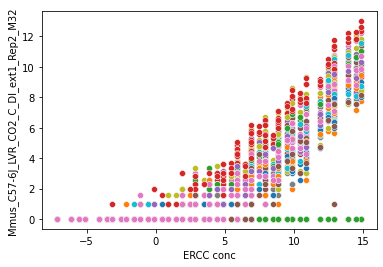

In [ ]:
columns = ercc_counts_mix_2.columns
for i in range(0, len(columns)-1):
  #print(columns[i])
  sns.scatterplot(x=np.log2(ercc_counts_mix_2['ERCC conc']), y=np.log2(ercc_counts_mix_2[columns[i]]+1))

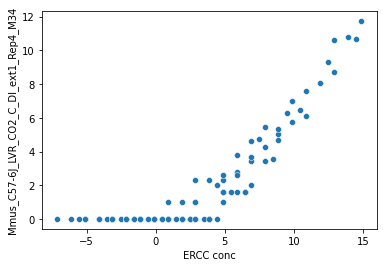

In [ ]:
columns = ercc_counts_mix_2.columns
counts = ercc_counts_mix_2[columns[1]]
sns.scatterplot(x=np.log2(ercc_counts_mix_2['ERCC conc']), y=np.log2(counts+1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


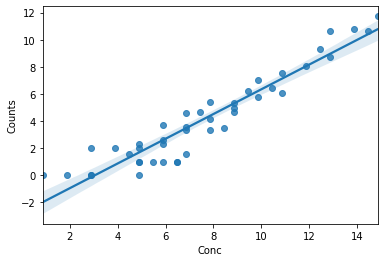

In [ ]:
counts = ercc_counts_mix_2[columns[1]]
counts.index.rename('Gene_ID', inplace=True)
countsdf = pd.DataFrame(counts)
countsdf
nonzero_counts = countsdf[ercc_counts_mix_2[columns[1]] > 0]
nonzero_counts['Conc'] = nonzero_counts.index.map(mix2_conc_dict)
nonzero_counts.columns = ['Counts','Conc']
nonzero_counts
sns.regplot(np.log2(nonzero_counts['Conc']), y=np.log2(nonzero_counts['Counts']))

In [ ]:
slope, intercept, r, p, se = linregress(np.log2(nonzero_counts['Conc']), y=np.log2(nonzero_counts['Counts']))
print(r)

0.948282986908978


In [ ]:
# Measure minimum detected
nonzero_counts.sort_values('Conc')
min = nonzero_counts.sort_values('Conc')['Conc'][0]
min

1.83105469

In [ ]:
# Measure maximum detected
nonzero_counts.sort_values('Conc')
max = nonzero_counts.sort_values('Conc', ascending=False)['Conc'][0]
max

30000.0

In [ ]:
dynamic_range = max / min
dynamic_range

16383.99997763038

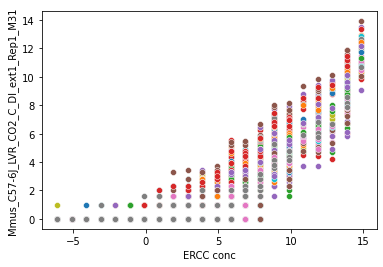

In [ ]:
columns = ercc_counts_mix_1.columns
for i in range(0, len(columns)-1):
  #print(columns[i])
  sns.scatterplot(x=np.log2(ercc_counts_mix_1['ERCC conc']), y=np.log2(ercc_counts_mix_1[columns[i]]+1))

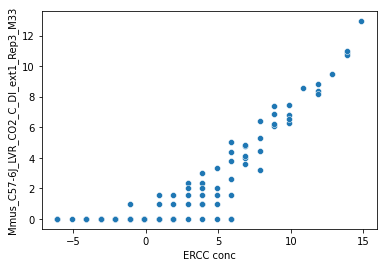

In [ ]:
columns = ercc_counts_mix_1.columns
sns.scatterplot(x=np.log2(ercc_counts_mix_1['ERCC conc']), y=np.log2(ercc_counts_mix_1[columns[1]]+1))

## Full Study ERCC Analysis
In some studies, Mix 1 and Mix 2 are added to samples in a way that allows the power of a study to be evaluated. For example, all flight samples may contain Mix 1 while all ground contain Mix 2. In this case, using the ERCC Dashboard package allows an assessment of DE analysis between flight and ground by using the know ratios of transcripts in the ERCC Mix 1 and Mix 2 standards.

In [ ]:
# Set-up notebook to allow inline running of R code
# Having done this, any code block starting with %RR will be run as R
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
# Install R libraries necessary
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("erccdashboard")
install.packages("pacman")

In [ ]:
# Load R libraries
%%R
library(erccdashboard)
pacman::p_load(base, datasets, graphics, grDevices, methods, edgeR, grid, gplots, gtools, limma, locfit, MASS, reshape2, ROCR, plyr, scales, stringr, qvalue,
               stats, tidyr, tidyverse, utils)

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: gridExtra



In [ ]:
%%R
citation("erccdashboard")


Please cite our paper when you use the erccdashboard package for
analysis.

  Munro SA et al. Assessing technical performance in differential gene
  expression experiments with external spike-in RNA control ratio
  mixtures. Nat. Commun. 5:5125 doi: 10.1038/ncomms6125 (2014)

A BibTeX entry for LaTeX users is

  @Article{,
    title = {Assessing technical performance in differential gene expression experiments with external spike-in RNA control ratio mixtures},
    author = {Munro SA and Lund SP and Pine PS and Binder H and Clevert D-A and Conesa A and Dopazo J and Fasold M and Hochreiter S and Hong H and Jafari N and Kreil DP and Labaj PP and Li S and Liao Y and Lin SM and Meehan J and Mason CE and Santoyo-Lopez J and Setterquist RA and Shi L and Shi W and Smyth GK and Stralis-Pavese N and Su Z and Tong W and Wang C and Wang J and Xu J and Ye Z and Yang Y and Yu Y and Salit M},
    journal = {Nat. Commun.},
    volume = {5},
    pages = {5125},
    year = {2014},
  }



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directory permission to upload files 
%cd ~

/root


In [ ]:
# Set MyDrive directory
%%R
work_dir="/content/drive/MyDrive"
plots_dir="/content/drive/MyDrive"
setwd(file.path(work_dir))

In [ ]:
# Load data by copying data's path from Google Drive
%%R
FS_LVR.countDat <- read.csv(Sys.glob("/content/drive/MyDrive/FS_LVR33.countDat.csv"), header = TRUE, stringsAsFactors = TRUE)
FS_LVR.totalReads <- read.csv(Sys.glob("/content/drive/MyDrive/FS_LVR33.totalReads.csv"), header = FALSE, stringsAsFactors = TRUE)
ERCCExFold <- read.csv(Sys.glob("/content/drive/MyDrive/ERCCExFold.csv"), header = TRUE, stringsAsFactors = TRUE)

In [ ]:
# Count data
%%R
head(FS_LVR.countDat)

             Feature LVRMix1_31 LVRMix1_33 LVRMix1_32 LVRMix1_34 LVRMix1_36
1 ENSMUSG00000000001         12         18          4          0          3
2 ENSMUSG00000000003          0          0          0          0          0
3 ENSMUSG00000000028          1          1          0          0          0
4 ENSMUSG00000000031         11          1          0          0          0
5 ENSMUSG00000000037          9          0          0          0          0
6 ENSMUSG00000000049         81        147         31         11         23
  LVRMix1_d7 LVRMix1_d9 LVRMix1_11 LVRMix1_12 LVRMix1_7 LVRMix1_9 LVRMix1_13
1          2          1          7         20         2         5         13
2          0          0          0          0         0         0          0
3          1          0          0          0         0         0          4
4          3          0          2          0         0         4          2
5          4          0          0          0         0         3         11
6     

In [ ]:
# Total sequenced reads of each column in count data
%%R
head(FS_LVR.totalReads)

        V1
1 84828509
2 54797359
3 48901977
4 51046641
5 47898001
6 56486206


In [ ]:
# ERCCExFold
%%R
head(ERCCExFold)

  ERCC.Expected Subpool Mix1Conc.Attomoles_ul Mix2Conc.Attomoles_ul
1    ERCC-00130    4:01             30000.000            7500.00000
2    ERCC-00004    4:01              7500.000            1875.00000
3    ERCC-00136    4:01              1875.000             468.75000
4    ERCC-00108    4:01               937.500             234.37500
5    ERCC-00116    4:01               468.750             117.18750
6    ERCC-00092    4:01               234.375              58.59375


In [ ]:
# exDat quick analysis
%%R
datType = "count" # "count" for RNA-Seq data
isNorm = FALSE # flag to indicate if input expression measures are already normalized,
               # default is FALSE
exTable = FS_LVR.countDat # expression measure table,                               
                           # names of genes or transcripts (Feature) in col1
filenameRoot = "FS" # user defined filename prefix for results files
sample1Name = "LVRMix1" # name for sample 1 in experiment, Mix 1
sample2Name = "LVRMix2" # name for sample 2 in experiment, Mix 2
erccmix = "RatioPair" # name of ERCC mixture design, "RatioPair" is default
erccdilution = 1/100 # dilution factor used for Ambion spike-in mixtures
spikeVol = 3 # volume (uL) of diluted spike-in mixture added to total RNA mass
totalRNAmass = 1.5 # mass (ug) of total RNA
choseFDR = 0.05 # user defined false discovery rate (FDR), default is 0.05 

exDat <- initDat(datType="count", isNorm = FALSE,
                 exTable=FS_LVR.countDat,
                 filenameRoot="FS", sample1Name="LVRMix1",
                 sample2Name="LVRMix2", erccmix="RatioPair",
                 erccdilution=1/100, spikeVol=3,
                 totalRNAmass=1.5, choseFDR=0.05)

summary(exDat)


Initializing the exDat list structure...
choseFDR = 0.05 
repNormFactor is NULL 
Filename root is: FS.LVRMix1.LVRMix2 

Transcripts were removed with a mean count < 1 or more than 2 
replicates with 0 counts.
Original data contained  55628 transcripts. 
After filtering  19921 transcripts remain for  analysis.
A total of 52 out of 92 
ERCC controls were filtered from the data set
The excluded ERCCs are:
ERCC-00012 ERCC-00013 ERCC-00016 ERCC-00017 ERCC-00019
ERCC-00024 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00039
ERCC-00040 ERCC-00041 ERCC-00048 ERCC-00051 ERCC-00054
ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00061 ERCC-00067
ERCC-00069 ERCC-00073 ERCC-00075 ERCC-00077 ERCC-00081
ERCC-00083 ERCC-00085 ERCC-00086 ERCC-00097 ERCC-00098
ERCC-00104 ERCC-00109 ERCC-00117 ERCC-00120 ERCC-00123
ERCC-00126 ERCC-00134 ERCC-00137 ERCC-00138 ERCC-00142
ERCC-00143 ERCC-00144 ERCC-00147 ERCC-00148 ERCC-00150
ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00163
ERCC-00164 ERCC-00168

repNormFactor is NUL

In [ ]:
# Estimate the mRNA fraction differences for the pair of samples using replicate data
%%R
exDat <- est_r_m(exDat)


Check for sample mRNA fraction differences(r_m)...

Number of ERCC Controls Used in r_m estimate
40 

Outlier ERCCs for GLM r_m Estimate:
ERCC-00162 ERCC-00062 ERCC-00095 ERCC-00078 ERCC-00079
ERCC-00060 ERCC-00076 ERCC-00112 ERCC-00022 ERCC-00042
ERCC-00116 ERCC-00009 ERCC-00003 ERCC-00004 ERCC-00046
ERCC-00002

GLM log(r_m) estimate:
-0.0988969 

GLM log(r_m) estimate weighted s.e.:
0.4272637 


In [ ]:
# Dynamic Range of abundance and ERCC signal is a qualitative assessment of expt, 2^16 dynamic range is desirable for RNAseq gene expression expt
%%R
exDat <- dynRangePlot(exDat, allPoints ="False", labelReps ="False")
grid.arrange(exDat$Figures$dynRangePlot)

In [ ]:
# geneExprTest by default for RNASeq unnormalized counts uses QuasiSeq, a negative binomial dispersion trend estimated from edgeR 
%%R
exDat <- geneExprTest(exDat)


Starting differential expression tests

Show log.offset
2.944439 2.079442 0.6931472 0.6931472 1.098612 2.302585 1.098612 2.079442 1.791759 0.6931472 1.791759 2.70805 2.197225 1.791759 1.791759 1.791759 2.302585 1.94591 1.791759 2.564949 1.609438 1.098612 1.791759 2.079442 1.94591 1.791759 2.079442 2.197225 1.609438 1.791759 1.386294 1.098612 1.791759 2.079442 2.197225 1.386294 2.564949 2.484907 2.639057 2.079442 2.564949 2.079442 1.386294 1.098612 3.258097 2.397895 2.079442 2.302585 2.639057 2.397895 2.397895 1.386294 1.791759 2.70805 1.94591 2.079442 1.791759 2.397895 2.197225 1.791759 2.079442 1.94591 3.218876 2.302585 1.386294 2.484907 
[1] 1
[1] 2
[1] 3
[1] 4
Disp = 0.62568 , BCV = 0.791 
Disp = 0.62534 , BCV = 0.7908 
Finished DE testing
Finished examining dispersions

Threshold P-value
0.0001974574 



Generating ROC curve and AUC statistics...

Area Under the Curve (AUC) Results:
 Ratio   AUC Detected Spiked
   4:1 1.000       10     23
 1:1.5 0.633       10     23
   1:2 0.838       11     23


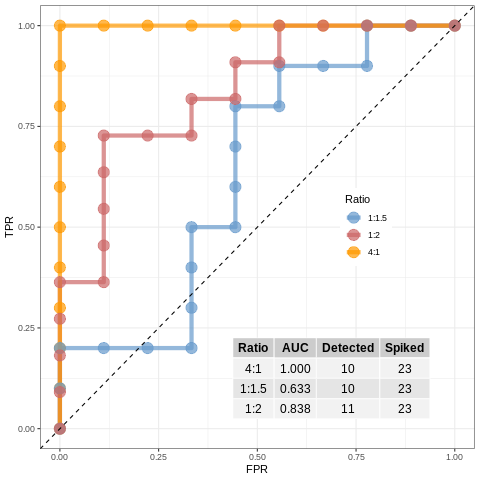

In [ ]:
# Receiver Operator Characteristic (ROC, true-pos and true-neg rank ordered DE test P-values) and Area Under the Curve (AUC) show diagnostic performance of detecting true differences 
# btwn expts using DE tests; AUC=1 best, AUC=0.5 random guess; FPR=False Pos Rate, TPR=True Pos Rate; higher seq depth result in more ERCC detection and more stringent ROC analysis
%%R
exDat <- erccROC(exDat)
grid.arrange(exDat$Figures$rocPlot)


Estimating ERCC LODR
.............................................
 Ratio LODR Estimate 90% CI Lower Bound 90% CI Upper Bound
   4:1           1.9               <1.7                  2
 1:1.5           Inf               <NA>               <NA>
   1:2           Inf               <NA>               <NA>

LODR estimates are available to code ratio-abundance plot


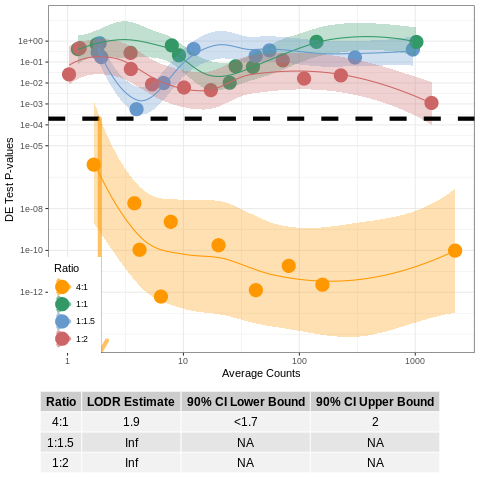

In [ ]:
# Estimate Limit of Detection of Ratios (LODR) estimates for each differential fold change; black dash line = p.thresh (threshold p-value); 
# LODR values compared btwn expts to detect sample differences as a function of transcript abundance
%%R
exDat <- estLODR(exDat, kind = "ERCC", prob = 0.9)
exDat <- annotLODR(exDat)
grid.arrange(exDat$Figures$lodrERCCPlot)


LODR estimates are available to code ratio-abundance plot


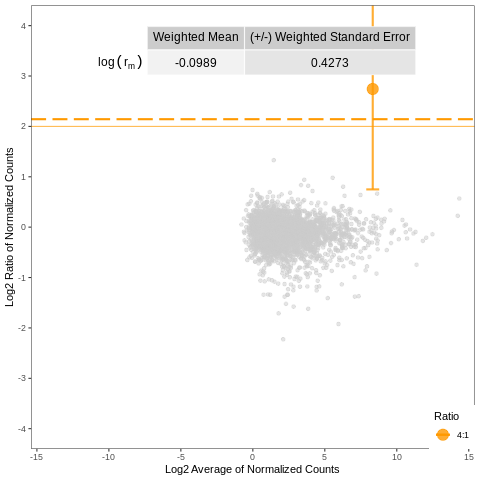

In [ ]:
# Generate MA plot 
%%R
exDat <- maSignal(exDat, alphaPoint = 0.8, r_mAdjust = TRUE, replicate = TRUE)
grid.arrange(exDat$Figures$maPlot)

In [ ]:
%%R
saveERCCPlots(exDat, plotsPerPg = "single", saveas = "pdf", outName = "Plots", plotlist = list(exDat$Figures$rocPlot, exDat$Figures$lodrERCCPlot, exDat$Figures$maPlot))

Printing plots to multiple pages in one PDF file.
png 
  2 


In [ ]:
# Save plots to local drive and MyDrive
from google.colab import files 
files.download('Plots.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>